In [1]:
import json

from pathlib import Path
from functools import partial
from collections import Counter
from bisect import bisect_left

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import coo_array
from tqdm.notebook import tqdm
from spacy.lang.de import German
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

* visualisierung von bow?

In [26]:
def iter_docs(in_path):
    with open(in_path, "r") as in_file:
        for iline, line in tqdm(enumerate(in_file), desc="load documents"):
            data = json.loads(line)
            yield data
            if iline > 3 and DEBUG:
                break
            
            
def iter_sents(docs):
    for doc in docs:
        text = doc['text']
        for isent, sent in tqdm(enumerate(nlp(text).sents), desc="load sentences"):
            sentence = []
            for token in sent:
                sentence.append(token.text)
            yield {
                'text': sentence,
                'sentence_id': isent,
                **{k:v for k,v in doc.items() if k!='text'}
            }
            if isent > 100 and DEBUG:
                break
                
def iter_chunks(docs, n_tokens=100):
    for doc in docs:
        tokenized = [t.text for t in nlp(doc['text'])]
        for i in range(0, len(tokenized), n_tokens):
            yield {
                'text': tokenized[i:i + n_tokens],
                **{k:v for k,v in doc.items() if k!='text'}
            }
            if i > 100//n_tokens and DEBUG:
                break

In [3]:
preprocessed_data_fn = Path("processed_data") / "eltec.jsonl"
DEBUG = True

nlp = German()
nlp.add_pipe("sentencizer")

for doc in iter_docs(preprocessed_data_fn):
    if len(doc['text']) >= nlp.max_length:
        nlp.max_length = len(doc['text'])+1

load documents: 0it [00:00, ?it/s]

## One-Hot

In [4]:
vocab, counts = zip(
    *Counter(
        [token.text for doc in iter_docs(preprocessed_data_fn) for token in nlp(doc['text'])]
    ).most_common(10000)
)
vocab = sorted(vocab)

load documents: 0it [00:00, ?it/s]

In [5]:
def get_index(query, vocab):
    'Locate the leftmost value exactly equal to x'
    i = bisect_left(vocab, query)
    if i != len(vocab) and vocab[i] == query:
        return i
    raise ValueError

def iter_embed_1hot(vocab, docs):
    for doc in docs:
        doc_i = []
        doc_j = []
        doc_data = []
        for itoken, token in enumerate(doc['text']):
            try:
                token_index = get_index(token, vocab)
                doc_i.append(itoken)
                doc_j.append(token_index)
                doc_data.append(1)
            except ValueError:
                pass
        yield coo_array((
            np.array(doc_data), 
            (
                np.array(doc_i, dtype=int),
                np.array(doc_j, dtype=int)
            )
        ), shape=(itoken+1, len(vocab)))

for embedding in iter_embed_1hot(vocab, iter_sents(iter_docs(preprocessed_data_fn))):
    break
embedding

load documents: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

<7x10000 sparse array of type '<class 'numpy.int64'>'
	with 6 stored elements in COOrdinate format>

## Bag of Words

In [6]:
def iter_embed_bow(vocab, docs):
    for one_hot in iter_embed_1hot(vocab, docs):
        yield one_hot.sum(axis=0)

for embedding in iter_embed_bow(vocab, iter_sents(iter_docs(preprocessed_data_fn))):
    break
embedding

load documents: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

array([0, 0, 0, ..., 0, 0, 0])

## Word 2 Vec

In [7]:
class W2VDataset:
    def __init__(self, generator_factory):
        self.generator_factory = generator_factory
        self.length = None
 
    def __iter__(self):
        generator = self.generator_factory()
        i=0
        for i, it in enumerate(generator):
            yield it['text']
            
        self.length = i+1
            
    def __len__(self):
        if self.length is not None:
            return self.length
        
        self.length = len([_ for _ in self])
        return self.length
        

def train_w2v(vector_size=50, window=5, min_count=1, max_vocab_size=10000):

    w2vdataset = W2VDataset(
        partial(
            iter_sents, 
            iter_docs(preprocessed_data_fn)
        )
    )

    model = Word2Vec(
        sentences=w2vdataset,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        max_vocab_size=max_vocab_size,
        workers=4
    )

    model.train(
        w2vdataset,
        total_examples=len(w2vdataset),
        epochs=2
    )

    wv = model.wv

    vocab = wv.index_to_key
    vocab = sorted(vocab)

    vecs = [wv[it] for it in vocab]

    return pd.DataFrame(data=vecs, index=vocab)

def iter_embed_w2v(vecs, docs):
    for doc in docs:
        doc_representation = []
        for itoken, token in enumerate(doc['text']):
            try:
                doc_representation.append(vecs.loc[token])
            except KeyError:
                pass # some tokens are not embedded
        yield np.vstack(doc_representation).mean(axis=0)
            
w2vs = train_w2v()

load documents: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

In [8]:
for embedding in iter_embed_w2v(w2vs, iter_sents(iter_docs(preprocessed_data_fn))):
    break
embedding

load documents: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

array([ 2.7373247e-04,  7.2854906e-03, -5.1993844e-03,  5.0230632e-03,
        1.2092715e-03,  1.1218805e-04, -5.5743949e-03, -5.1842397e-03,
        3.1515904e-04,  3.1842445e-03,  2.2177775e-03,  7.5706281e-04,
       -5.2672531e-04,  5.4775341e-03,  3.9532171e-03,  1.1914975e-03,
        3.6298714e-03,  4.2449124e-04, -1.1749525e-03,  5.4250224e-03,
        1.0548354e-03, -1.8847699e-03,  2.9134203e-03,  3.6376982e-03,
        1.1144866e-02,  5.0928834e-04,  4.5575765e-03,  4.0103616e-03,
        9.3402639e-03, -1.0714171e-03, -1.2632079e-03, -4.4532050e-03,
        8.6910330e-04,  8.4126099e-05, -4.9049342e-03, -2.6495350e-03,
        1.1115774e-02,  5.0631003e-03,  5.8988333e-03,  1.0165824e-02,
        7.4725291e-03, -2.3734423e-03, -5.9106094e-03,  1.8854730e-03,
       -1.0577255e-02, -2.8110829e-03,  1.0663941e-02, -7.2936271e-03,
        4.0689502e-03,  6.1968309e-03], dtype=float32)

## Authorship attribution

In [24]:
def train_simple_classifier(iterator, label_string):
    
    data = list(iterator)
    labels = [it[label_string] for it in data]
    features = np.vstack(list(iter_embed_bow(vocab, data)))
    
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

    clf = Pipeline([
            ("scaler", StandardScaler()),
            ("classifier", LogisticRegression(random_state=13198)),
    ])
    
    
    clf = clf.fit(train_features, train_labels)
    
    
    pred_labels = clf.predict(test_features)
    
    return f1_score(test_labels, pred_labels, average='macro')

In [25]:
train_simple_classifier(iter_chunks(iter_docs(preprocessed_data_fn)), 'author-name')

load documents: 0it [00:00, ?it/s]

0.3333333333333333

In [27]:
scores = []
chunk_sizes = [5, 10, 100, 1000]

for chunk_size in chunk_sizes:
    iterator = iter_chunks(iter_docs(preprocessed_data_fn), n_tokens=chunk_size)
    scores.append(
        train_simple_classifier(iterator, 'author-name')
    )

load documents: 0it [00:00, ?it/s]

load documents: 0it [00:00, ?it/s]

load documents: 0it [00:00, ?it/s]

load documents: 0it [00:00, ?it/s]

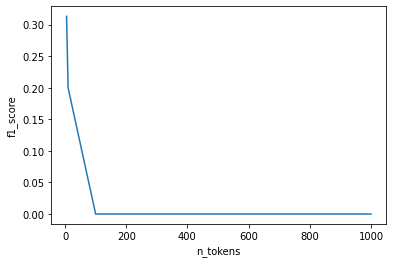

In [28]:
fig, ax = plt.subplots()
ax.plot(chunk_sizes, scores, label="f1_score")
ax.set_xlabel("n_tokens")
ax.set_ylabel("f1_score")
plt.show()